# Exploring the Sentinel 2 STAC catalog tools

In [1]:
import geopandas as gpd
import leafmap
import matplotlib.pyplot as plt
import rasterio

from pathlib import Path

from geospatial_tools import DATA_DIR
from geospatial_tools.stac import StacSearch, PLANETARY_COMPUTER
from geospatial_tools.utils import create_date_range_for_specific_period

## Visualizing Sentinel 2 tiles

Below, we load up the Sentinel 2 griding tiles so we can determine which grid most fits with our needs. 
In this demonstration, we will be looking the southern Jackson Demonstration State Forest, which
is inside the `10SJD` tile. 

In [2]:
S2_USA_GRID_FILE = DATA_DIR / "s2_grid_usa_polygon_5070.gpkg"
s2_grid = gpd.read_file(S2_USA_GRID_FILE)

m = leafmap.Map(center=[39.3, -124.16], zoom=8)
m.add_gdf(s2_grid, layer_name='s2_grid', style={"color": "red"})
m

Map(center=[39.3, -124.16], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

## Search Parameters

Now we search for our product.

In this demonstration, we want relatively recent products, and only from June or July

We are looking for Sentinel 2 products that are already pre-processed and that have 
minimal cloud cover.

We are also limiting our search to the `10SDJ` tile.



In [3]:
# Date ranges
start_year = 2023
end_year = 2024
start_month = 6
end_month = 7
date_ranges = create_date_range_for_specific_period(start_year=start_year,
                                                    end_year=end_year,
                                                    start_month_range=start_month,
                                                    end_month_range=end_month)

# Search arguments
collection = "sentinel-2-l2a"
tile_ids = ["10SDJ"]
max_cloud_cover = 1
max_no_data_value = 5
query = {"eo:cloud_cover": {"lt": max_cloud_cover}, "s2:mgrs_tile": {"in": tile_ids}}
sortby = [{"field": "properties.eo:cloud_cover", "direction": "asc"}]

# Searching for results
search_client = StacSearch(PLANETARY_COMPUTER)
search_client.search_for_date_ranges(date_ranges=date_ranges,
                                     collections=collection,
                                     query=query,
                                     sortby=sortby, limit=100)

# Selecting optimal result
search_client.sort_results_by_cloud_coverage()
search_client.filter_no_data(property_name="s2:nodata_pixel_percentage", max_no_data_value=max_no_data_value)

filtered_items = search_client.filtered_results
optimal_result = filtered_items[0]

# Printing relevant information about
print("\nSorted results")
for item in filtered_items:
    print(f"Item: {item.id}, {item.datetime}, "
          f"Cloud cover: {item.properties['eo:cloud_cover']}, "
          f"Nodata: {item.properties['s2:nodata_pixel_percentage']}")

print(f"\nOptimal result: {optimal_result.id}, {optimal_result.datetime}, "
      f"Cloud cover: {optimal_result.properties['eo:cloud_cover']}, "
      f"Nodata: {optimal_result.properties['s2:nodata_pixel_percentage']}")


Sorted results
Item: S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205, 2023-07-21 18:59:21.024000+00:00, Cloud cover: 0.004333, Nodata: 0.0
Item: S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205, 2023-07-21 18:59:21.024000+00:00, Cloud cover: 0.004333, Nodata: 0.0
Item: S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205, 2023-07-21 18:59:21.024000+00:00, Cloud cover: 0.004333, Nodata: 0.0
Item: S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346, 2024-07-05 18:59:21.024000+00:00, Cloud cover: 0.006778, Nodata: 1.7e-05
Item: S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346, 2024-07-05 18:59:21.024000+00:00, Cloud cover: 0.006778, Nodata: 1.7e-05
Item: S2A_MSIL2A_20240705T185921_R013_T10SDJ_20240706T050346, 2024-07-05 18:59:21.024000+00:00, Cloud cover: 0.006778, Nodata: 1.7e-05
Item: S2B_MSIL2A_20230726T185919_R013_T10SDJ_20241010T041620, 2023-07-26 18:59:19.024000+00:00, Cloud cover: 0.035783, Nodata: 0.0
Item: S2B_MSIL2A_20230726T185919_R013_T10SDJ_20241010T0

In [4]:
bands = ["B02", "B03", "B04", "B08", "visual"]
file_base_path = Path(f"{DATA_DIR}/sentinel-2/")
best_result = search_client.download_best_cloud_cover_result(bands=bands, base_directory=file_base_path)
best_result

In [5]:
best_result.show_asset_items()

[2026-01-29 16:23:48] INFO       [MainThread][geospatial_tools.stac] Asset list for asset [S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205] : 
	['ID: [S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205], Band: [B02], filename: [/home/francispelletier/projects/geospatial_tools/data/sentinel-2/S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205_B02.tif]', 'ID: [S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205], Band: [B03], filename: [/home/francispelletier/projects/geospatial_tools/data/sentinel-2/S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205_B03.tif]', 'ID: [S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205], Band: [B04], filename: [/home/francispelletier/projects/geospatial_tools/data/sentinel-2/S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205_B04.tif]', 'ID: [S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205], Band: [B08], filename: [/home/francispelletier/projects/geospatial_tools/data/sentinel-2/S2A_MSIL2A_20230721T185921_R013_T10SDJ_202

In [6]:
merged = best_result.merge_asset(base_directory=file_base_path, delete_sub_items=True)

[2026-01-29 16:24:12] INFO       [MainThread][geospatial_tools.stac] Deleting [/home/francispelletier/projects/geospatial_tools/data/sentinel-2/S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205_visual.tif] ...


In [7]:
merged

PosixPath('/home/francispelletier/projects/geospatial_tools/data/sentinel-2/S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205_merged.tif')

In [8]:
reprojected = best_result.reproject_merged_asset(target_projection=5070, 
                                                 base_directory=file_base_path,
                                                 delete_merged_asset=True)

[2026-01-29 16:25:04] INFO       [MainThread][geospatial_tools.stac] Deleting merged asset file for [/home/francispelletier/projects/geospatial_tools/data/sentinel-2/S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205_merged.tif]


In [9]:
reprojected

PosixPath('/home/francispelletier/projects/geospatial_tools/data/sentinel-2/S2A_MSIL2A_20230721T185921_R013_T10SDJ_20240911T103205_reprojected.tif')

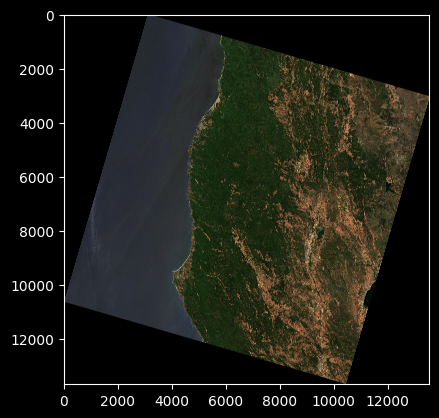

In [10]:
image_path = str(reprojected)

with rasterio.open(image_path) as src:
    bands = src.read((5,6,7))
    plt.imshow(bands.transpose(1, 2, 0)) 
    plt.show()